In [203]:
from pprint import pprint
import numpy as np
import fatf

import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.models as fatf_models

import fatf.transparency.predictions.surrogate_explainers as fatf_surrogates

import fatf.vis.lime as fatf_vis_lime

print(__doc__)

from fatf.utils.data.discretisation import Discretiser
import fatf.utils.models.models as fumm

from typing import Dict  # pylint: disable=unused-import
from typing import List, Optional, Union, Tuple
Index = Union[int, str]
BinSamplingValues = Dict[Union[str, int],
                         Dict[int, Tuple[float, float, float, float]]]
Explanation = Dict[str, Dict[str, float]]
ExplanationSurrogate = Union[Dict[str, fumm.Model], fumm.Model]
ExplanationTuple = Union[Explanation,  # yapf: disable
                         Tuple[Explanation, ExplanationSurrogate]]
from numbers import Number


import fatf.utils.array.tools as fuat
import fatf.utils.array.validation as fuav
import fatf.utils.data.augmentation as fuda
import fatf.utils.data.discretisation as fudd
import fatf.utils.data.transformation as fudt
import fatf.utils.distances as fud
import fatf.utils.kernels as fatf_kernels
import fatf.utils.models.validation as fumv
import fatf.utils.models.models as fumm

import fatf.utils.tools as fut

from fatf.transparency.predictions.surrogate_explainers import SurrogateTabularExplainer
try:
    # pylint: disable=ungrouped-imports
    import sklearn
    import sklearn.linear_model
    import sklearn.tree

    import fatf.transparency.sklearn.linear_model as ftslm
    import fatf.utils.data.feature_selection.sklearn as fudfs

    _SKLEARN_VERSION = [int(i) for i in sklearn.__version__.split('.')[:2]]
    _SKLEARN_0_22 = fut.at_least_verion([0, 22], _SKLEARN_VERSION)
except ImportError as exin:
    warnings.warn(
        'The TabularBlimeyLime and TabularBlimeyTree surrogate explainers '
        'require scikit-learn to be installed. Since scikit-learn is missing, '
        'this functionality will be disabled.', UserWarning)
    logger.error(str(exin))

    ReturnTree = None  # pylint: disable=invalid-name
    SKLEARN_MISSING = True
else:
    if _SKLEARN_0_22:  # pragma: nocover
        # pylint: disable=invalid-name,protected-access,no-member
        ReturnTree = sklearn.tree._classes.BaseDecisionTree
    else:  # pragma: nocover
        ReturnTree = (  # pylint: disable=invalid-name
            sklearn.tree.tree.BaseDecisionTree)
    SKLEARN_MISSING = False
    
import logging
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name
import scipy

import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.datasets import make_moons, make_circles

Automatically created module for IPython interactive environment


In [53]:
from typing import Any, Dict, Set, Union

import matplotlib.pyplot as plt


BlimeyExplanation = Dict[str, float]

def plot_lime(surrogate_explanation: Union[BlimeyExplanation,
                                           Dict[str, BlimeyExplanation]],
              ax=None,
              ) -> plt.Figure:
    """
    Plots an importance-based surrogate explanation, e.g., LIME.
    This plotting function is intended for the :class:`fatf.transparency.\
predictions.surrogate_explainers.TabularBlimeyLime` and :class:`fatf.\
transparency.predictions.surrogate_explainers.TabularBlimeyTree` explainers.
    When multiple explanations are provided, they will share a common y-axis
    if they use the same set of interpretable features.
    Parameters
    ----------
    surrogate_explanation : Dictionary[string, float] or \
Dictionary[string, Dictionary[string, float]]
        An explanation returned by the ``explain_instance`` method of a
        surrogate explainer. For a classifier this will be a dictionary where
        the keys are class names and the values are dictionaries where the key
        is an interpretable feature name and the value is the importance of
        this interpretable feature. For regressor explanations this will be
        a dictionary where the key is an interpretable feature name and the
        value is the importance of this interpretable feature.
        .. versionchanged:: 0.1.0
           Dropped support for LIME explanation format:
           ``List[Tuple[string, float]]`` for regressors and
           ``Dictionary[string, List[Tuple[string, float]]]`` for probabilistic
           classifiers.
        .. versionchanged:: 0.0.2
           Support for surrogate explainer explanations of the form:
           ``Dictionary[string, Dictionary[string, float]]``.
    Raises
    ------
    TypeError
        The ``surrogate_explanation`` parameter is not a dictionary. One of the
        class names is not a string. One of the interpretable feature names is
        not a string. One of the importance values is not a number.
    ValueError
        One of the explanations is an empty dictionary.
    Returns
    -------
    figure : matplotlib.pyplot.Figure
        A matplotlib figure with subplots explaining every label in a surrogate
        explanation.
    """

    # pylint: disable=too-many-locals,too-many-branches,too-many-statements

    def validate(explanation):
        is_valid = False
        if isinstance(explanation, dict):
            if not explanation:
                raise ValueError('One of the explanations is an empty '
                                 'dictionary.')
            for key, value in explanation.items():
                if not isinstance(key, str):
                    raise TypeError('One of the explanation keys is not a '
                                    'string.')
                if not isinstance(value, Number):
                    raise TypeError('One of the explanation values is not a '
                                    'number.')
        else:
            raise TypeError('One of the explanations is not a dictionary.')
        is_valid = True
        return is_valid

    if isinstance(surrogate_explanation, dict):
        if not surrogate_explanation:
            raise ValueError('The surrogate explanation is an empty '
                             'dictionary.')

        example_key = sorted(surrogate_explanation.keys())[0]
        example_explanation = surrogate_explanation[example_key]
        # Nested dictionary for classification
        if isinstance(example_explanation, dict):
            for class_name, explanation in surrogate_explanation.items():
                if not isinstance(class_name, str):
                    raise TypeError('One of the class names is not a string.')
                assert validate(explanation), 'Invalid input.'
            plot_explanation = surrogate_explanation  # type: Any
        # Plain dictionary for regression
        elif isinstance(example_explanation, Number):
            assert validate(surrogate_explanation), 'Invalid input.'
            plot_explanation = {'': surrogate_explanation}
        else:
            raise TypeError('Each value of the surrogate explanation must '
                            'either be a dictionary or a number.')
    else:
        raise TypeError('The surrogate explanation has to be a dictionary.')

    # Collect all of the class names and their number
    class_names = sorted(plot_explanation.keys())
    class_n = len(class_names)

    # Check whether all of the explanations share the same key names
    share_y = True
    fig_shape = (1, class_n)
    #
    explanation_label_set_old = set()  # type: Set[str]
    for class_explanation in plot_explanation.values():
        if not explanation_label_set_old:
            explanation_label_set_old = set(class_explanation.keys())
        else:
            explanation_labels_set = set(class_explanation.keys())
            if explanation_label_set_old != explanation_labels_set:
                share_y = False
                fig_shape = (class_n, 1)
                logger.info('The explanations cannot share the y-axis as they '
                            'use different sets of interpretable features.')
                break

    # If sharing y-axis get a common ordering of the explanations
    if share_y:
        name_ordering = sorted(plot_explanation[class_names[0]].keys())

    if ax is None:
        figure, axes = plt.subplots(*fig_shape, sharey=share_y, sharex=True)
        figure.suptitle('Surrogate Explanation')
    else:
        axes=ax

    # Do the plotting
    for i in range(class_n):
        class_name = class_names[i]
        class_explanation = plot_explanation[class_name]

        # Make sure that all bar plots are in the same order if sharing
        if share_y:
            exp_names = name_ordering
        else:
            exp_names = sorted(class_explanation.keys())
        exp_values = [class_explanation[name] for name in exp_names]

        positions = [i + 0.5 for i in range(len(class_explanation))]
        colours = ['green' if val > 0 else 'red' for val in exp_values]

        if class_n == 1:
            # For a single sub-plot this is not iterable
            axis = axes
        else:
            axis = axes[i]
        axis.barh(positions, exp_values, align='center', color=colours)
        axis.set_yticks(positions)
        axis.set_yticklabels(exp_names)

#         axis.set_title('{}'.format(class_name))

#     return figure

In [19]:
class QuartileDiscretiser(Discretiser):
    """
    Discretises selected numerical features of the ``dataset`` into quartiles.
    .. versionadded:: 0.0.2
    This class discretises numerical columns (features) of the ``dataset`` by
    mapping their values onto quartile ids to which they belong. The quartile
    boundaries are computed based of the ``dataset`` used to initialise this
    class.
    Parameters
    ----------
    dataset : numpy.ndarray
        A 2-dimensional numpy array with a dataset to be discretised.
    categorical_indices : List[column indices], optional (default=None)
        A list of column indices that should be treat as categorical features.
        If ``None`` is given, this will be inferred from the ``dataset`` array:
        string-based columns will be treated as categorical features and
        numerical columns will be treated as numerical features.
    feature_names : List[strings], optional (default=None)
        A list of feature names in order they appear in the ``dataset`` array.
        If ``None``, this will be extracted from the ``dataset`` array. For
        structured arrays these will be the column names extracted from the
        dtype; for classic arrays these will be numbers indicating the column
        index in the array.
    Warns
    -----
    UserWarning
        If some of the string-based columns in the input data array were not
        indicated to be categorical features by the user (via the
        ``categorical_indices`` parameter) the user is warned that they will be
        added to the list of categorical features.
    Raises
    ------
    IncorrectShapeError
        The input ``dataset`` is not a 2-dimensional numpy array.
    IndexError
        Some of the column indices given in the ``categorical_indices`` list
        are invalid for the input ``dataset``.
    TypeError
        The ``dataset`` is not of a base (numerical and/or string) type.
        The ``categorical_indices`` is neither a Python list nor ``None``.
        The ``feature_names`` is neither a Python list nor ``None`` or one of
        its elements (if it is a list) is not a string.
    ValueError
        The length of the ``feature_names`` list is different than the number
        of columns (features) in the input ``dataset``.
    Attributes
    ----------
    dataset_dtype : numpy.dtype
        The dtype of the input ``dataset``.
    is_structured : boolean
        ``True`` if the input ``dataset`` is a structured numpy array,
        ``False`` otherwise.
    features_number : integer
        The number of features (columns) in the input ``dataset``.
    categorical_indices : List[Column Indices]
        A list of column indices that should be treat as categorical features.
    numerical_indices : List[Column Indices]
        A list of column indices that should be treat as numerical features.
    feature_names_map : Dict[Column Index, String]
        A dictionary that holds mapping of column (feature) indices to their
        names (feature names). If the ``feature_names`` parameter was not given
        (``None``), the feature names are inferred from the ``dataset``.
    feature_value_names : Dictionary[Index, Dictionary[Integer, String]]
        A dictionary mapping ``dataset`` column (feature) indices to
        dictionaries holding quartile description (value) of each quartile id
        (key) for that feature.
    feature_bin_boundaries : Dictionary[Index, numpy.ndarray]
        A dictionary mapping ``dataset`` column (feature) indices to numpy
        arrays holding quartile bin boundaries (with the upper boundary
        inclusive) for each feature.
    discretised_dtype : numpy.dtype
        The dtype of the discretised arrays output by the ``discrete`` method.
    """

    # pylint: disable=too-few-public-methods

    def __init__(self,
                 dataset: np.ndarray,
                 categorical_indices: Optional[List[Index]] = None,
                 feature_names: Optional[List[str]] = None,
                 percentile_qartile = [25, 50, 75],
                ) -> None:
        """
        Constructs a ``QuartileDiscretiser`` object.
        """
        super().__init__(
            dataset,
            categorical_indices=categorical_indices,
            feature_names=feature_names)

        # Prepare dtype of the discretised array
        if self.is_structured:
            self.discretised_dtype = []  # type: List[np.dtype]
            for feature in self.dataset_dtype.names:
                if feature in self.numerical_indices:
                    self.discretised_dtype.append((feature, np.int8))
                else:
                    self.discretised_dtype.append(
                        (feature, self.dataset_dtype[feature]))
        else:
            if self.categorical_indices:
                self.discretised_dtype = self.dataset_dtype
            else:
                self.discretised_dtype = np.int8

#         percentile_qartile = [25, 50, 75]

        for feature in self.numerical_indices:
            if self.is_structured:
                qts = np.percentile(dataset[feature], percentile_qartile)
            else:
                qts = np.percentile(dataset[:, feature], percentile_qartile)
            self.feature_bin_boundaries[feature] = qts

            feature_name = self.feature_names_map[feature]

            self.feature_value_names[feature] = {
                0: '*{}* <= {:.2f}'.format(feature_name, qts[0]),
                qts.shape[0]: '{:.2f} < *{}*'.format(qts[-1], feature_name)
            }
            for i in range(1, qts.shape[0]):
                bin_name = '{:.2f} < *{}* <= {:.2f}'.format(
                    qts[i - 1], feature_name, qts[i])
                self.feature_value_names[feature][i] = bin_name

    def discretise(self, dataset: Union[np.ndarray, np.void]
                   ) -> Union[np.ndarray, np.void]:
        """
        Discretises numerical features of the ``dataset`` into quartiles.
        Parameters
        ----------
        dataset : Union[numpy.ndarray, numpy.void]
            A data point (1-D) or an array (2-D) of data points to be
            discretised.
        Raises
        ------
        IncorrectShapeError
            The input ``dataset`` is neither 1- nor 2-dimensional numpy array.
            The number of features (columns) in the input ``dataset`` is
            different than the number of features in the dataset used to
            initialise this object.
        TypeError
            The dtype of the input ``dataset`` is too different from the dtype
            of the dataset used to initialise this object.
        Returns
        -------
        discretised_data : Union[numpy.ndarray, numpy.void]
            A discretised data array.
        """
        self._validate_input_discretise(dataset)

        if self.is_structured and fuav.is_1d_like(dataset):
            discretised_dataset = dataset.copy().astype(self.discretised_dtype)
        else:
            discretised_dataset = np.zeros_like(
                dataset, dtype=self.discretised_dtype)

        for feature in self.categorical_indices:
            if self.is_structured or fuav.is_1d_array(dataset):
                discretised_dataset[feature] = dataset[feature]
            else:
                discretised_dataset[:, feature] = dataset[:, feature]

        for feature, boundaries in self.feature_bin_boundaries.items():
            if self.is_structured or fuav.is_1d_array(dataset):
                discretised_dataset[feature] = np.searchsorted(
                    boundaries, dataset[feature])
            else:
                discretised_dataset[:, feature] = np.searchsorted(
                    boundaries, dataset[:, feature])

        return discretised_dataset

In [26]:
class TabularBlimeyLime(SurrogateTabularExplainer):
    """
    A tabular LIME explainer -- a surrogate explainer based on a linear model.
    .. versionchanged:: 0.1.0
       (1) Added support for regression models.
       (2) Changed the feature selection mechanism from k-LASSO to
       :func:`~fatf.utils.data.feature_selection.sklearn.forward_selection`
       when the number of selected features is less than 7, and
       :func:`~fatf.utils.data.feature_selection.sklearn.highest_weights`
       otherwise -- the default LIME behaviour.
    .. versionadded:: 0.0.2
    This class implements Local Interpretable Model-agnostic Explanations
    (LIME_) introduced by [RIBEIRO2016WHY]_. This implementation mirrors the
    one in the `official LIME package`_, which is available under the
    ``lime.lime_tabular.LimeTabularExplainer`` class therein.
    This explainer uses a quartile discretiser
    (:class:`fatf.utils.data.discretisation.QuartileDiscretiser`) and a normal
    sampler (:class:`fatf.utils.data.augmentation.NormalSampling`) for
    augmenting the data. The following steps are taken to generate the
    explanation (when the ``explain_instance`` method is called):
    * The input ``data_row`` is discretised using the quartile discretiser.
      The numerical features are binned and the categorical ones are left
      unchanged (selected via the ``categorical_indices`` parameter).
    * The data are sampled around the discretised ``data_row`` using the normal
      sampler. Since after the discretisation all of the features are
      categorical the bin indices are sampled based on their frequency
      in (the discretised version of) the ``dataset`` used to initialise this
      class.
    * The sampled data are reverted back to their original domain and predicted
      with the black-box model (``predictive_model`` used to initialise this
      class). This step is done via sampling each (numerical) feature value
      from the corresponding bin using the truncated normal distribution for
      which minimum (lower threshold), maximum (upper threshold), mean and
      standard deviation are computed empirically from all the data points from
      the ``dataset`` for which feature values fall into that bin. The
      categorical features are left unchanged.
    * The discretised sampled data set is binarised by comparing each row with
      the user-specified ``data_row`` (in the ``explain_instance`` method).
      This step is performed by taking XNOR logical operation between the two
      -- 1 if the feature value is the same in a row of the discretised data
      set and the ``data_row`` and 0 if it is different.
    * The Euclidean distance between the binarised sampled data and binarised
      ``data_row`` is computed and passed through an exponential kernel
      (:func:`fatf.utils.kernels.exponential_kernel`) to get similarity scores,
      which will be used as data point weights when reducing the number of
      features (see below) and training the linear regression.
    * To limit the number of features in the explanation (if enabled by the
      user) we either use *forward selection* when the number of selected
      features is less than 7 or *highest weights* otherwise. (This is
      controlled by the ``features_number`` parameter in the
      ``explain_instance`` method and by default -- ``features_number=None`` --
      all of the feature are used.)
    * A local (weighted) ridge regression (``sklearn.linear_model.Ridge``) is
      fitted to the sampled and binarised data with the target being:
      - The numerical predictions of the black-box model when the underlying
        model is a regression.
      - A vector of probabilities output by the black-box model for the
        selected class (one-vs-rest) when the underlying model is a
        probabilistic classifier. By default, one model is trained for all of
        the classes (``explained_class=None`` in the ``explain_instance``
        method), however the class to be explained can be specified by the
        user.
    .. note:: How to interpret the results?
       Because the local surrogate model is trained on the binarised sampled
       data that is parsed through the XNOR operation, the parameters extracted
       from this model (feature importances) should be interpreted as an answer
       to the following question:
           "Had this particular feature value of the explained data point
           been outside of this range (for numerical features) or had a
           different value (for categorical feature), how would that influence
           the *probability of this point belonging to the explained class*
           (probabilistic classification) / *predicted numerical value*
           (regression)?"
    This LIME implementation is limited to black-box
    **probabilistic classifiers** and **regressors** (similarly to the
    `official implementation`_). Therefore, the ``predictive_model`` must have
    a ``predict_proba`` method for probabilistic models and ``predict`` method
    for regressors. When the surrogate is built for a probabilistic classifier,
    the local model will be trained using the **one-vs-rest** approach since
    the output of the global model is an array with probabilities of each class
    (the classes to be explained can be selected using the ``explained_class``
    parameter in the ``explain_instance`` method). The column indices indicated
    as categorical features (via the ``categorical_indices`` parameter) will
    not be discretised.
    For detailed instructions on how to build a custom surrogate explainer
    (to avoid tinkering with this class) please see the
    :ref:`how_to_tabular_surrogates` *how-to guide*.
    For additional parameters, warnings and errors description please see the
    documentation of the parent class :class:`fatf.transparency.predictions.\
surrogate_explainers.SurrogateTabularExplainer`.
    .. _LIME: https://github.com/marcotcr/lime
    .. _`official LIME package`: https://github.com/marcotcr/lime
    .. _`official implementation`: https://github.com/marcotcr/lime/blob/
       master/lime/lime_tabular.py#L357
    .. [RIBEIRO2016WHY] Ribeiro, M.T., Singh, S. and Guestrin, C., 2016,
       August. Why should i trust you?: Explaining the predictions of any
       classifier. In Proceedings of the 22nd ACM SIGKDD international
       conference on knowledge discovery and data mining (pp. 1135-1144). ACM.
    Parameters
    ----------
    dataset : numpy.ndarray
        A 2-dimensional numpy array with a dataset (utilised in various ways
        throughout the explainer).
    predictive_model : object
        A pre-trained (black-box) predictive model to be explained. If
        ``as_probabilistic`` (see below) is set to ``True``, it must have a
        ``predict_proba`` method that takes a data set as the only required
        input parameter and returns a 2-dimensional numpy array with
        probabilities of belonging to each class. Otherwise, if
        ``as_probabilistic`` is set to ``False``, the ``predictive_model`` must
        have a ``predict`` method that outputs a 1-dimensional array with
        (class) predictions.
    as_regressor : boolean, optional (default=False)
        .. versionadded:: 0.1.0
        A boolean indicating whether the global model should be treated as
        regression (``True``) or probabilistic classification (``False``).
    categorical_indices : List[column indices], optional (default=None)
        A list of column indices in the input ``dataset`` that should be
        treated as categorical features.
    class_names : List[string], optional (default=None)
        A list of strings defining the names of classes. If the predictive
        model is probabilistic, the order of the class names should correspond
        to the order of columns output by the model. For other models the
        order should correspond to lexicographical ordering of all the possible
        outputs of this model. For example, if the model outputs
        ``['a', 'c', '0']`` the class names should be given for
        ``['0', 'a', 'c']`` ordering.
    feature_names : List[string], optional (default=None)
        A list of strings defining the names of the ``dataset`` features. The
        order of the names should correspond to the order of features in the
        ``dataset``.
    Raises
    ------
    ImportError
        The scikit-learn package is missing.
    Attributes
    ----------
    discretiser : fatf.utils.data.discretisation.Discretiser
        An instance of the quartile discretiser
        (:class:`fatf.utils.data.discretisation.QuartileDiscretiser`)
        initialised with the input ``dataset`` and used to discretise
        the ``data_row`` when the ``explain_instance`` method is called.
    augmenter : fatf.utils.data.augmentation.Augmentation
        An instance of the normal sampling augmenter
        (:class:`fatf.utils.data.augmentation.NormalSampling`)
        used to sample new data points around the discretised ``data_row``
        (in the ``explain_instance`` method).
    bin_sampling_values : Dictionary[dataset column index, \
Dictionary[discretised bin id, Tuple(float, float, float, float)]]
        A dictionary holding characteristics for each bin of each numerical
        feature. The characteristic are represented as a 4-tuple consisting of:
        the lower bin boundary, the upper bin boundary, the empirical mean of
        of all the values of this feature for data points (in ``dataset``)
        falling into that bin, and the empirical standard deviation (calculated
        in the same way). For the edge bins, if there are data available the
        lower edge is calculated empirically (as the minimum of the
        corresponding feature values falling into that bin), otherwise it is
        set to ``-numpy.inf``. The same applies to the upper edge, which is
        either set to ``numpy.inf`` or calculated empirically (as the maximum
        of the corresponding feature values falling into that bin).
        If there are no data points to calculate the mean and standard
        deviation for a given bin, these two values are set to ``numpy.nan``.
        (This does not influence the future reverse sampling, for which this
        attribute is used: since there were no data for a given bin, the
        frequency of data for that bin is 0, therefore no data falling into
        this bin will be sampled.)
    """

    # pylint: disable=too-few-public-methods

    def __init__(self,
                 dataset: np.ndarray,
                 predictive_model: object,
                 as_regressor: bool = False,
                 categorical_indices: Optional[List[Index]] = None,
                 class_names: Optional[List[str]] = None,
                 feature_names: Optional[List[str]] = None,
                 percentile_qartile=None
                ) -> None:
        """
        Constructs a ``TabularBlimeyLime`` class.
        """
        # pylint: disable=too-many-arguments,too-many-locals,too-many-branches

        if SKLEARN_MISSING:
            raise ImportError('The scikit-learn package is required to use '
                              'the TabularBlimeyLime explainer.')

        # The implementation of the tabular LIME explainer only supports
        # probabilistic classifiers and regressors, hence does not require
        # unique prediction values and the number of classes.
        # (as_probabilistic=True; classes_number=None; unique_predictions=None)
        super().__init__(dataset, predictive_model, True, as_regressor,
                         categorical_indices, class_names, None, feature_names,
                         None)

        self.discretiser = QuartileDiscretiser(
            dataset,
            categorical_indices=self.categorical_indices,
            feature_names=self.feature_names,
            percentile_qartile=percentile_qartile,
            
        )

        # The discretiser transforms each numerical feature into a categorical
        # (integer) feature that indicates to which bin a particular value
        # belongs.
        dataset_discretised = self.discretiser.discretise(self.dataset)

        # Since the dataset is discretised, the NormalSampling augmenter will
        # sample unique values for each column (categorical values for
        # categorical features and bin IDs for numerical features)
        # proportionally to their frequency in the discretised dataset.
        self.augmenter = fuda.NormalSampling(
            dataset_discretised, categorical_indices=self.column_indices)

        # Get empirical characteristics (minimum, maximum, mean and standard
        # deviation) for each bin of a numerical feature. If a bin is empty
        # (no data), use the quartile boundaries.
        bin_sampling_values = {}  # type: BinSamplingValues
        for index in self.numerical_indices:
            bin_sampling_values[index] = {}

            if self.is_structured:
                discretised_feature = dataset_discretised[index]
                feature = self.dataset[index]
            else:
                discretised_feature = dataset_discretised[:, index]
                feature = self.dataset[:, index]

            # The bin IDs need to be sorted as they are retrieved from
            # dictionary keys (hence may come in a random order), therefore
            # interfering with the enumerate procedure.
            bin_ids = sorted(
                list(self.discretiser.feature_value_names[index].keys()))
            bin_boundaries = self.discretiser.feature_bin_boundaries[index]
            for bin_i, bin_id in enumerate(bin_ids):
                bin_feature_indices = (discretised_feature == bin_id)
                bin_feature_values = feature[bin_feature_indices]

                # If there is data in the bin, get its empirical mean and
                # standard deviation, otherwise use numpy nan.
                # If there are no data in a bin, the frequency of this bin
                # will be 0, therefore data will never get sampled from this
                # bin, i.e., there will be no attempt to undiscretised them.
                if bin_feature_values.size:
                    mean_val = bin_feature_values.mean()
                    std_val = bin_feature_values.std()
                else:
                    mean_val = np.nan
                    std_val = np.nan

                # Use the true bin boundaries (extracted from the discretiser).
                # For the edge bins (with -inf and +inf edges) use the
                # empirical minimum and maximum (if possible) to avoid problems
                # with reverse sampling (see the _undiscretise_data method).
                if bin_i == 0:
                    if bin_feature_values.size:
                        min_val = bin_feature_values.min()
                    else:
                        min_val = -np.inf  # pragma: nocover
                        assert False, (  # pragma: nocover
                            'Since the upper bin boundary is inclusive in '
                            'the quartile discretiser this can never happen.')
                    max_val = bin_boundaries[bin_i]
                # This is bin id count (+1) and not bind boundary count.
                elif bin_i == bin_boundaries.shape[0]:
                    min_val = bin_boundaries[bin_i - 1]
                    if bin_feature_values.size:
                        max_val = bin_feature_values.max()
                    else:
                        max_val = np.inf
                else:
                    min_val = bin_boundaries[bin_i - 1]
                    max_val = bin_boundaries[bin_i]

                bin_sampling_values[index][bin_id] = (min_val, max_val,
                                                      mean_val, std_val)
        self.bin_sampling_values = bin_sampling_values

    def _explain_instance_input_is_valid(  # type: ignore
            self, data_row: Union[np.ndarray, np.void],
            explained_class: Union[None, int, str], samples_number: int,
            features_number: Union[None, int],
            kernel_width: Union[None, float], return_models: bool) -> bool:
        """
        Validates the input parameters of the ``explain_instance`` method.
        For additional documentation of the input parameters, warnings and
        errors please see the description of :func:`fatf.transparency.\
predictions.surrogate_explainers.TabularBlimeyLime.explain_instance` method.
        Returns
        -------
        is_valid : boolean
            ``True`` if the input parameters are valid, ``False`` otherwise.
        """
        # pylint: disable=too-many-arguments,too-many-branches
        # pylint: disable=arguments-differ
        is_valid = False
        assert super()._explain_instance_input_is_valid(data_row)

        if explained_class is not None:
            if not isinstance(explained_class, (int, str)):
                raise TypeError('The explained_class parameter must be either '
                                'None, a string or an integer.')

        if isinstance(samples_number, int):
            if samples_number < 1:
                raise ValueError('The samples_number parameter must be a '
                                 'positive integer (larger than 0).')
        else:
            raise TypeError('The samples_number parameter must be an integer.')

        if features_number is not None:
            if isinstance(features_number, int):
                if features_number < 1:
                    raise ValueError('The features_number parameter must be a '
                                     'positive integer (larger than 0).')
            else:
                raise TypeError('The features_number parameter must either be '
                                'None or an integer.')

        if kernel_width is not None:
            if isinstance(kernel_width, Number):
                if kernel_width <= 0:
                    raise ValueError('The kernel_width parameter must be a '
                                     'positive float (larger than 0).')
            else:
                raise TypeError('The kernel_width parameter must either be '
                                'None or a float.')

        if not isinstance(return_models, bool):
            raise TypeError('The return_models parameter must be a boolean.')

        is_valid = True
        return is_valid

    def _undiscretise_data(self, discretised_data: np.ndarray) -> np.ndarray:
        """
        Transforms discretised data set into its original representation.
        The ``discretised_data`` are reverted back to their original domain by
        sampling each (numerical) feature value from the corresponding bin
        using the truncated normal distribution for which minimum (lower
        threshold), maximum (upper threshold), mean and standard deviation were
        computed empirically from all the data points in the ``dataset``
        (used to initialise this class) for which feature values fall into that
        bin. The categorical features are left unchanged.
        This method mimics the "un-discretisation" procedure done by the
        `official LIME implementation`_.
        .. _`official LIME implementation`: https://github.com/marcotcr/lime/
          blob/master/lime/discretize.py
        Parameters
        ----------
        discretised_data : numpy.ndarray
            A discretised data set to be reverted back to the original
            representation (domain).
        Returns
        -------
        undiscretised_data : numpy.ndarray
            The ``discretised_data`` reverted back to the original
            representation (domain).
        """
        # pylint: disable=too-many-locals
        assert fuav.is_2d_array(discretised_data), 'Not a 2-D array.'

        # Create a placeholder for undiscretised data. We copy the discretised
        # array instead of creating an empty one to preserve the values of
        # sampled categorical features, hence we do not need to copy them
        # later on. We also need to change the type of the array to correspond
        # to the original dataset.
        undiscretised_data = discretised_data.copy().astype(self.dataset.dtype)

        for index in self.numerical_indices:
            if self.is_structured:
                discretised_column = discretised_data[index]
                undiscretised_column = undiscretised_data[index]
            else:
                discretised_column = discretised_data[:, index]
                undiscretised_column = undiscretised_data[:, index]

            unique_column_values = np.unique(discretised_column)
            for bin_id, bin_values in self.bin_sampling_values[index].items():
                if bin_id in unique_column_values:
                    # Since sampling values must have been found in this bin,
                    # there should be an empirical mean (2) and
                    # standard deviation (3).
                    # yapf: disable
                    assert (self.bin_sampling_values[index][bin_id][2]
                            is not np.nan), ('No empirical mean for a bin '
                                             'without data points.')
                    assert (self.bin_sampling_values[index][bin_id][3]
                            is not np.nan), ('No empirical standard deviation '
                                             'for a bin without data points.')
                    # yapf: enable

                    bin_indices = np.where(discretised_column == bin_id)[0]
                    samples_number = bin_indices.shape[0]

                    min_, max_, mean_, std_ = bin_values
                    if std_:
                        lower_bound = (min_ - mean_) / std_
                        upper_bound = (max_ - mean_) / std_

                        unsampled = scipy.stats.truncnorm.rvs(
                            lower_bound,
                            upper_bound,
                            loc=mean_,
                            scale=std_,
                            size=samples_number)
                    else:
                        unsampled = np.array(samples_number * [mean_])

                    undiscretised_column[bin_indices] = unsampled

        return undiscretised_data

    def explain_instance(self,
                         data_row: Union[np.ndarray, np.void],
                         explained_class: Optional[Union[int, str]] = None,
                         samples_number: int = 50,
                         features_number: Optional[int] = None,
                         kernel_width: Optional[float] = None,
                         return_models: bool = False) -> ExplanationTuple:
        """
        Explains the ``data_row`` with linear regression feature importance.
        .. versionchanged:: 0.1.0
           Changed the feature selection mechanism from k-LASSO to
           :func:`~fatf.utils.data.feature_selection.sklearn.forward_selection`
           when the number of selected features is less than 7, and
           :func:`~fatf.utils.data.feature_selection.sklearn.highest_weights`
           otherwise -- the default LIME behaviour.
        For probabilistic classifiers the explanations will be produced for all
        of the classes by default. This can be changed by selecting a specific
        class with the ``explained_class`` parameter.
        The default ``kernel_width`` is computed as the square root of the
        number of features multiplied by 0.75. Also, by default, all of the
        (interpretable) features will be used to create an explanation, which
        can be limited by setting the ``features_number`` parameter. The data
        sampling around the ``data_row`` can be customised by specifying the
        number of points to be generated (``samples_number``).
        By default, this method only returns feature importance, however
        by setting ``return_models`` to ``True``, it will also return the local
        linear surrogates for further analysis and processing done outside of
        this method.
        .. note::
           The exact description of the explanation generation procedure can
           be found in the documentation of this class (:class:`fatf.\
transparency.predictions.surrogate_explainers.TabularBlimeyLime`).
        For additional parameters, warnings and errors please see the parent
        class method :func:`fatf.transparency.predictions.\
surrogate_explainers.SurrogateTabularExplainer.explain_instance`.
        Parameters
        ----------
        data_row : Union[numpy.ndarray, numpy.void]
            A data point to be explained (1-dimensional numpy array).
        explained_class : Union[integer, string], optional (default=None)
            The class to be explained -- only applicable to probabilistic
            classifiers. If ``None``, all of the classes will be
            explained. This can either be the index of the class (the column
            index of the probabilistic vector) or the class name (taken from
            ``self.class_names``).
        samples_number : integer, optional (default=50)
            The number of data points sampled from the normal augmenter, which
            will be used to fit the local surrogate model.
        features_number : integer, optional (default=None)
            The maximum number of (interpretable) features -- found with
            *forward selection* or *highest weights* -- to be used in the
            explanation (the local surrogate model is trained with this feature
            subset). By default (``None``), all of the (interpretable) features
            are used.
        kernel_width : float, optional (default=None)
            The width of the exponential kernel used when computing weights of
            the sampled data based on the distances between the sampled data
            and the ``data_row``.The default ``kernel_width``
            (``kernel_width=None``) is computed as the square root of the
            number of features multiplied by 0.75.
        return_models : boolean, optional (default=False)
            If ``True``, this method will return both the feature importance
            explanation dictionary and a dictionary holding the local models.
            Otherwise, only the first dictionary will be returned.
        Raises
        ------
        TypeError
            The ``explained_class`` parameter is neither ``None``, an integer
            or a string. The ``samples_number`` parameter is not an integer.
            The ``features_number`` parameter is neither ``None`` nor an
            integer. The ``kernel_width`` parameter is neither ``None`` nor
            a number. The ``return_models`` parameter is not a boolean.
        ValueError
            The ``samples_number`` parameter is a non-positive integer (smaller
            than 1). The ``features_number`` parameter is a non-positive
            integer (smaller than 1). The ``kernel_width`` parameter is a
            non-positive number (smaller or equal to 0).
            The ``explained_class`` specified by the user could neither be
            recognised as one of the allowed class names (``self.class_names``)
            nor an index of a class name.
        Returns
        -------
        explanations : Dictionary[string, Dictionary[string, float]]
            A dictionary holding dictionaries that contain feature
            importance -- where the feature names are taken from
            ``self.feature_names`` and the feature importances are extracted
            from local linear surrogates. These dictionaries are held under
            keys corresponding to class names (taken from
            ``self.class_names``).
        models : sklearn.linear_model.base.LinearModel, optional
            A dictionary holding locally fitted surrogate linear models
            held under class name keys (taken from ``self.class_names``).
            This dictionary is only returned when the ``return_models``
            parameter is set to ``True``.
        """
        # pylint: disable=too-many-arguments,too-many-locals,too-many-branches
        # pylint: disable=arguments-differ,too-many-statements
        assert self._explain_instance_input_is_valid(
            data_row, explained_class, samples_number, features_number,
            kernel_width, return_models), 'Invalid input.'

        dataset_features_number = len(self.column_indices)

        if kernel_width is None:
            kernel_width = np.sqrt(dataset_features_number) * 0.75

        # Discretise data row
        data_row_discretised = self.discretiser.discretise(data_row)
        # Sample around the discretised data row (in the discretised domain)
        sampled_data_discretised = self.augmenter.sample(
            data_row_discretised, samples_number=samples_number)

        # Revert back the sampled data into the original domain
        sampled_data = self._undiscretise_data(sampled_data_discretised)

        # Get predictions of the sampled data
        sampled_data_predictions = self.predictive_function(sampled_data)

        # Binarise the sampled data, i.e., XNOR (in the discretised domain)
        # The value will be 1 if the same as in the data_row and 0 if different
        binarised_data = fudt.dataset_row_masking(sampled_data_discretised,
                                                  data_row_discretised)
        binarised_data = fuat.as_unstructured(binarised_data)

        # Get similarity measure (weights) by kernelising the distance
        # (in the binary domain). The data_row is represented as an all-1
        # vector in the binarised domain as 1s indicate that it lies in all.
        # of the numerical bins and has the came categorical feature values
        # as the original data_row.
        distances = fud.euclidean_point_distance(
            np.ones(dataset_features_number), binarised_data)
        weights = fatf_kernels.exponential_kernel(
            distances, width=kernel_width)

        # Get feature names for the binarised domain
        binarised_data_feature_names = []
        for i, index in enumerate(self.column_indices):
            feature_value = data_row_discretised[index]

            if index in self.discretiser.numerical_indices:
                feature_value = feature_value.astype(int)
                binarised_data_feature_names.append(
                    self.discretiser.feature_value_names[index][feature_value])
            else:
                binarised_data_feature_names.append('*{}* = {}'.format(
                    self.feature_names[i], feature_value))

        # Get classes to be explained
        if self.as_regressor:
            classes_to_explain = [None]  # type: List[Union[None, int]]
        else:
            assert (self.classes_number is not None
                    and self.class_names is not None)
            if explained_class is None:
                classes_to_explain = list(range(self.classes_number))
            elif isinstance(explained_class, str):
                if explained_class not in self.class_names:
                    raise ValueError('The *{}* explained class name was not '
                                     'recognised. The following class names '
                                     'are allowed: {}.'.format(
                                         explained_class, self.class_names))
                # Translate the class name into a probability index
                classes_to_explain = [self.class_names.index(explained_class)]
            elif isinstance(explained_class, int):
                if (explained_class < 0  # yapf: disable
                        or explained_class >= self.classes_number):
                    raise ValueError('The explained class index is out of the '
                                     'allowed range: 0 to {} (there are {} '
                                     'classes altogether).'.format(
                                         self.classes_number - 1,
                                         self.classes_number))
                classes_to_explain = [explained_class]
            else:
                assert False, (  # pragma: nocover
                    'Cannot be anything else but None, string or int.')

        # Filter features
        if features_number is None:
            features_number = len(self.column_indices)
        if features_number < 7:
            _feature_selection_algo = 'forward selection'
        else:
            _feature_selection_algo = 'highest weights'
        logger.info('Selecting %d features with %s.', features_number,
                    _feature_selection_algo)

        # Generate the explanations
        if self.as_regressor:
            assert len(classes_to_explain) == 1
            assert classes_to_explain[0] is None
        else:
            assert self.as_probabilistic, (
                'The loop below assumes the sampled_data_predictions array to '
                'be a vector of probabilities since the '
                'self.predictive_function has to be probabilistic -- this '
                'implementation of LIME does not support non-probabilistic '
                'classifiers.')
        explanations = {}
        models = {}
        for class_index in classes_to_explain:
            if self.as_regressor:
                assert class_index is None
                class_name = None
                predictions = sampled_data_predictions
            else:
                assert self.class_names is not None and class_index is not None
                class_name = self.class_names[class_index]
                # Select the predictions of the class to be explained
                predictions = sampled_data_predictions[:, class_index]

            # Filter features
            if features_number < 7:
                selected_indices = fudfs.forward_selection(
                    binarised_data, predictions, weights, features_number)
            else:
                selected_indices = fudfs.highest_weights(
                    binarised_data, predictions, weights, features_number)
            selected_training_data = binarised_data[:, selected_indices]
            # The returned indices can either be strings (structured) or
            # integers (classic). In this case they have to be integers because
            # the discretised data set is classic.
            assert isinstance(selected_indices[0],
                              np.integer), 'Classic array.'
            selected_feature_names = [
                binarised_data_feature_names[i]  # type: ignore
                for i in selected_indices
            ]

            # Train the local (weighted) ridge regression and use our
            # linear model explainer to generate explanations.
            local_model = sklearn.linear_model.Ridge()
            local_model.fit(
                selected_training_data, predictions, sample_weight=weights)

            # Get a linear model explainer
            explainer = ftslm.SKLearnLinearModelExplainer(
                local_model, feature_names=selected_feature_names)

            # Extract feature importance explanations from the linear model
            assert explainer.feature_names is not None, 'Defined above.'

            if self.as_regressor:
                assert class_index is None and class_name is None
                explanations = dict(
                    zip(explainer.feature_names,
                        explainer.feature_importance()))
                models = local_model
            else:
                assert class_name is not None
                explanations[class_name] = dict(
                    zip(explainer.feature_names,
                        explainer.feature_importance()))
                models[class_name] = local_model

        if return_models:
            return_ = (explanations, models)  # type: ExplanationTuple
        else:
            return_ = explanations
        return return_


In [57]:
from sklearn.neural_network import MLPClassifier as NN

# Fix random seed
fatf.setup_random_seed(42)

# Load data
iris_data_dict = fatf_datasets.load_iris()
iris_X = iris_data_dict['data']
iris_y = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_class_names = iris_data_dict['target_names'].tolist()

# Train a model
# clf = fatf_models.KNN()
clf = NN(max_iter=5000)
clf.fit(iris_X, iris_y)



21-Jul-01 11:15:32 fatf         INFO     Seeding RNGs using the input parameter.
21-Jul-01 11:15:32 fatf         INFO     Seeding RNGs with 42.


MLPClassifier(max_iter=5000)

In [56]:
print(fatf_models)

<module 'fatf.utils.models' from '/export/sphere/rodan/cuboid-workspace/rp13102/miniconda3/lib/python3.7/site-packages/fatf/utils/models/__init__.py'>


0

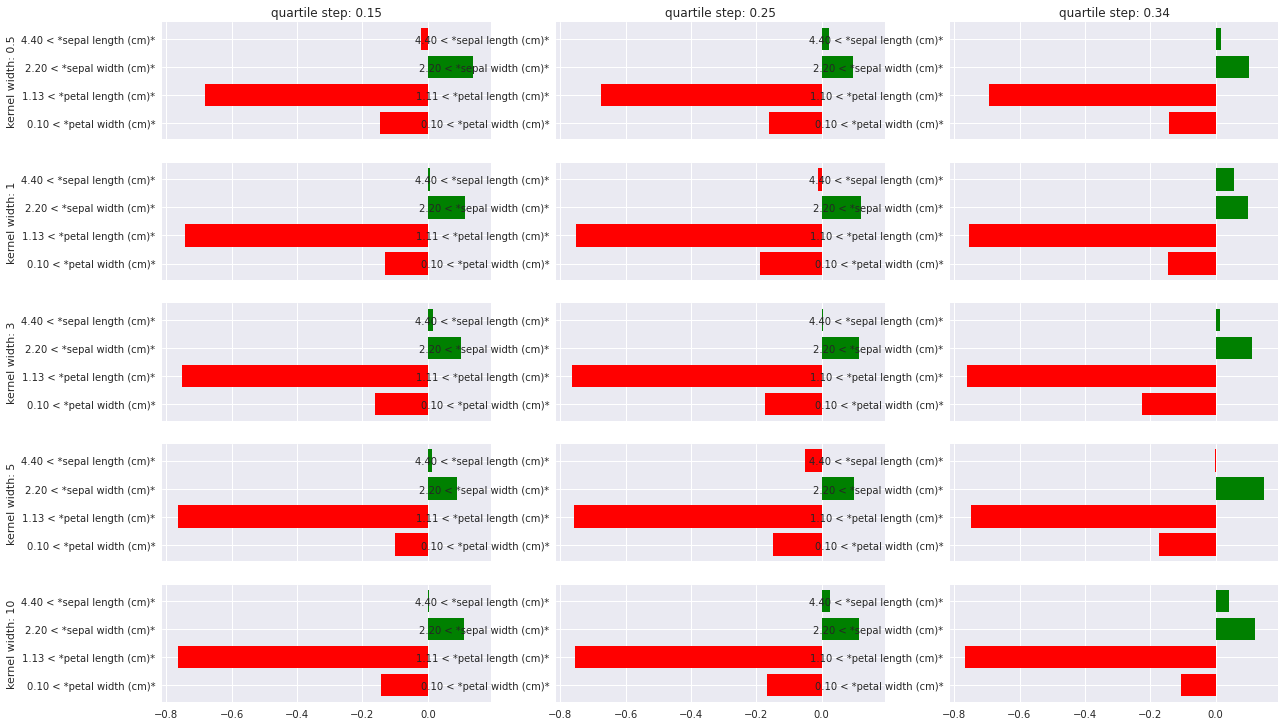

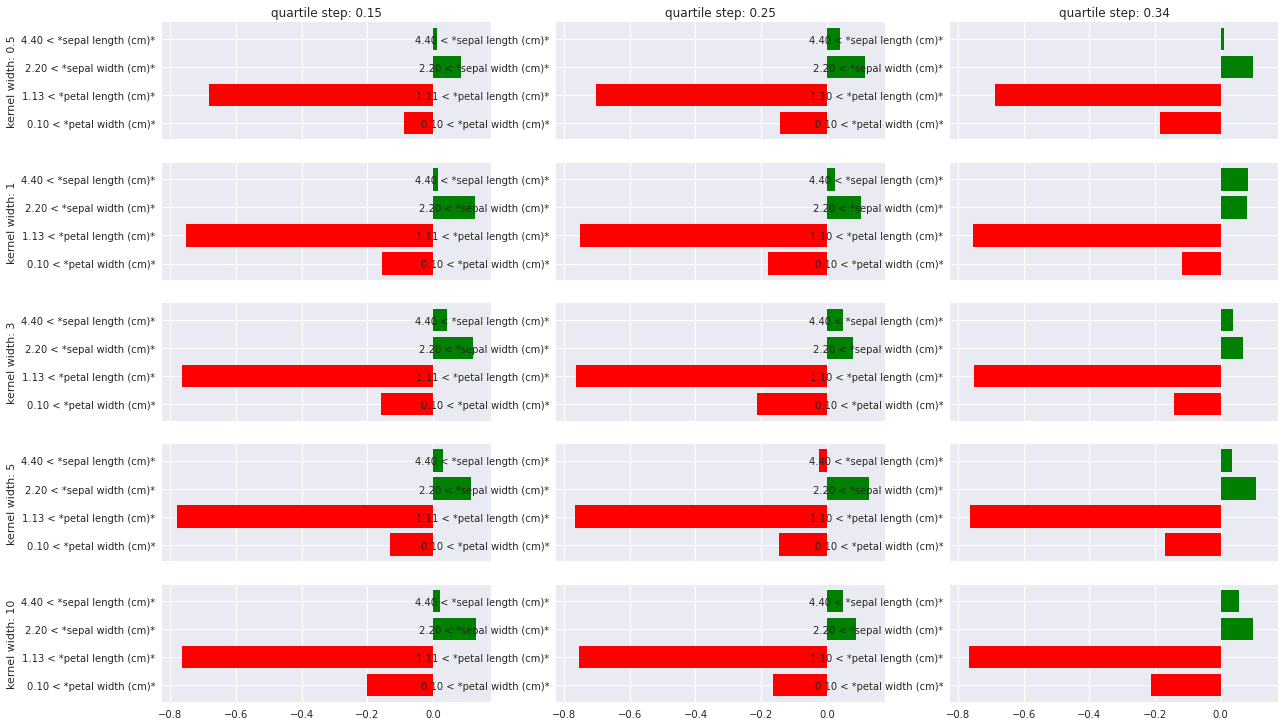

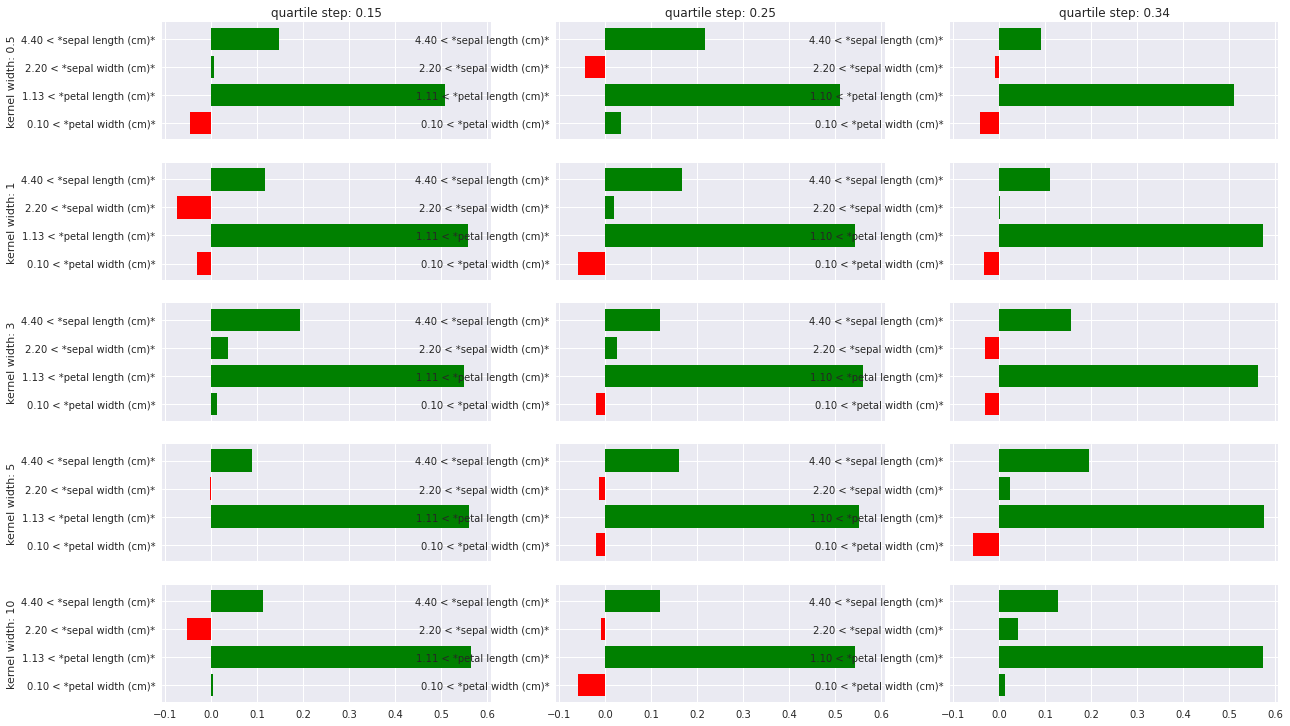

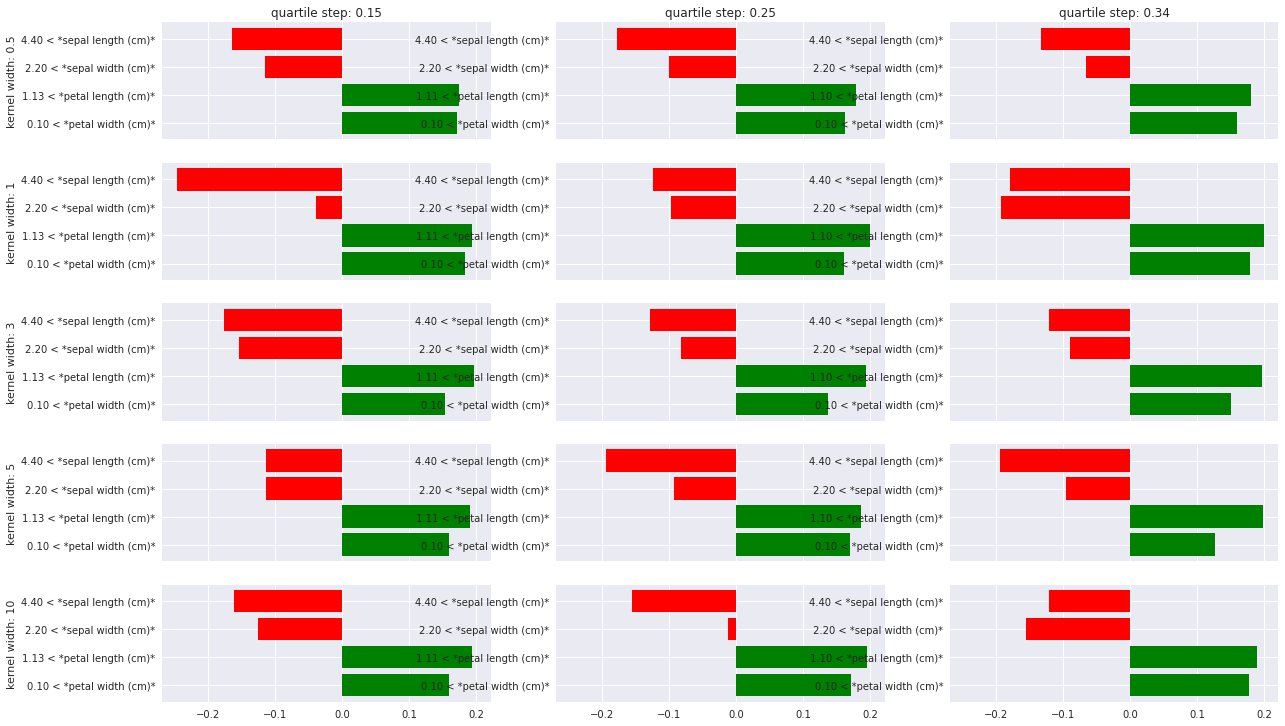

In [91]:

# Explain an instance
kws = [0.5, 1, 3, 5, 10]
steps = [0.15, 0.25, 0.34]


for index_to_explain in [10, 30, 50, 70]:
    
    fig, axes = plt.subplots(len(kws), len(steps), figsize=(20, 2.5*len(kws)), sharex=True)
    
    _class = int(clf.predict(iris_X[index_to_explain, :].reshape(1, -1))[0])
    
    for jj, step in enumerate(steps):
        percentile_qartile=np.arange(step, 1, step).tolist()

        # Create a LIME explainer
        lime = TabularBlimeyLime(
            iris_X,
            clf,
            feature_names=iris_feature_names,
            class_names=iris_class_names,
            percentile_qartile=percentile_qartile
        )

        for ii, kw in enumerate(kws):
            lime_explanation = lime.explain_instance(
                iris_X[index_to_explain, :],
                samples_number=5000,
                kernel_width=kw,
                explained_class=_class,
            )

            # Display the textual explanation
            # pprint(lime_explanation)

            # Plot the explanation
            plot_lime(lime_explanation, ax=axes[ii, jj])
            if jj == 0:
                axes[ii, 0].set_ylabel(f'kernel width: {kw}')
        axes[0, jj].set_title(f'quartile step: {step}')

In [93]:
import fatf.utils.data.augmentation as fatf_augmentation


In [132]:

iris = fatf_datasets.load_iris()

iris_selected_features = [0, 1]

iris_target = iris['target'].astype(np.int16)
iris_target_names = iris['target_names']

iris_data = iris['data']
iris_feature_names = iris['feature_names'][iris_selected_features]

In [199]:
def _explain(clf, X, x, kw, n_samples=5000, C=1.0, penalty='l2'):

    sampler = fatf_augmentation.NormalSampling(X)
    sampled_data = sampler.sample(
        x,
        samples_number=n_samples
    )

    pred = int(clf.predict(x.reshape(1, -1)))
    sampled_data_prediction = clf.predict(
        sampled_data
    )

    distance_normal = fatf_distances.euclidean_point_distance(
        x, sampled_data)

    # Kernel width is set to the default value in the LIME implementation
    sample_weights = fatf_kernels.exponential_kernel(
        distance_normal, width=kw)

    surrogate = LogisticRegression(
        penalty=penalty,
        C=C,
        fit_intercept=True,
        max_iter=10000,
    )
    surrogate.fit(sampled_data, sampled_data_prediction,
                    sample_weight=sample_weights)
    
    score0 = surrogate.score(sampled_data, sampled_data_prediction)
    score1 = surrogate.score(sampled_data, sampled_data_prediction, sample_weight=sample_weights)
    
    return surrogate.coef_.ravel(), [score0, score1]

In [205]:
X, y = make_circles(n_samples=500, noise=0.15, factor=0.20)
clf = NN(max_iter=5000).fit(X, y)

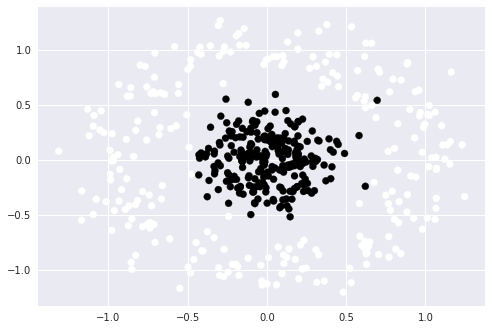

In [206]:
plt.scatter(X[:, 0], X[:, 1], c=y)

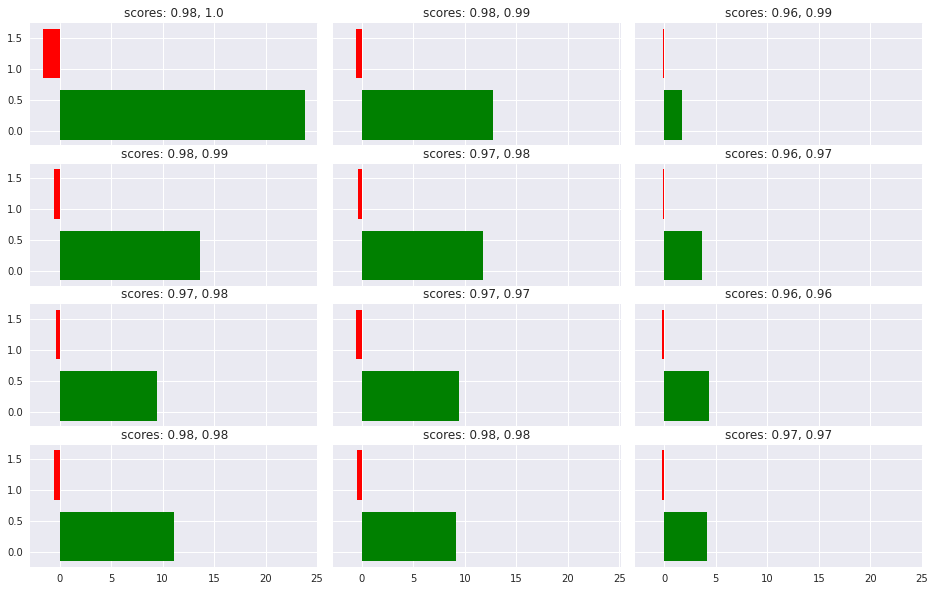

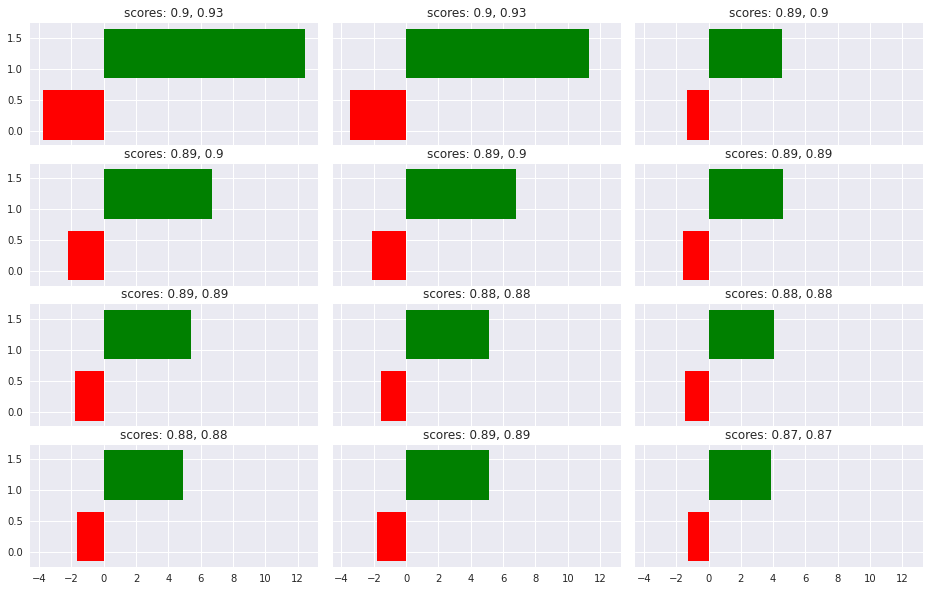

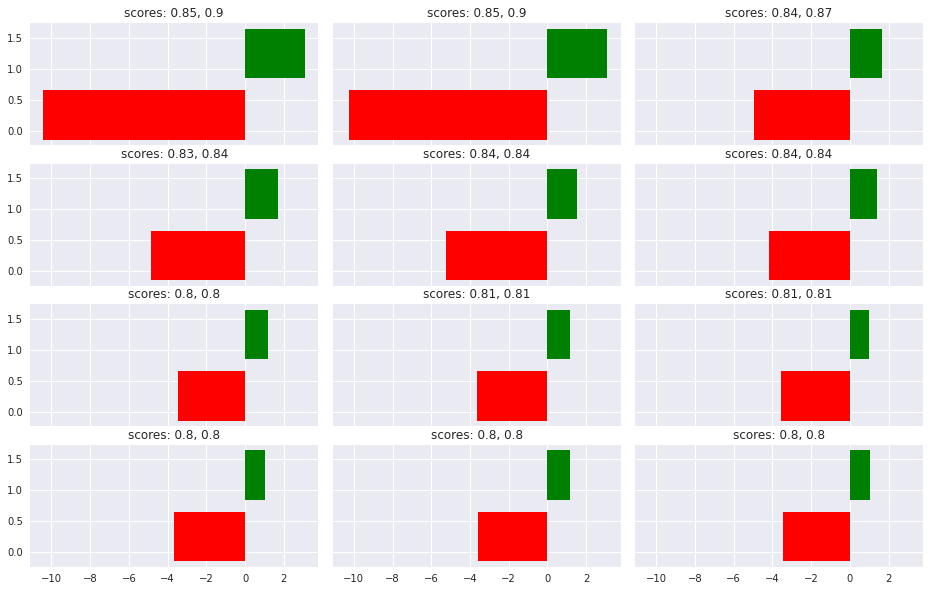

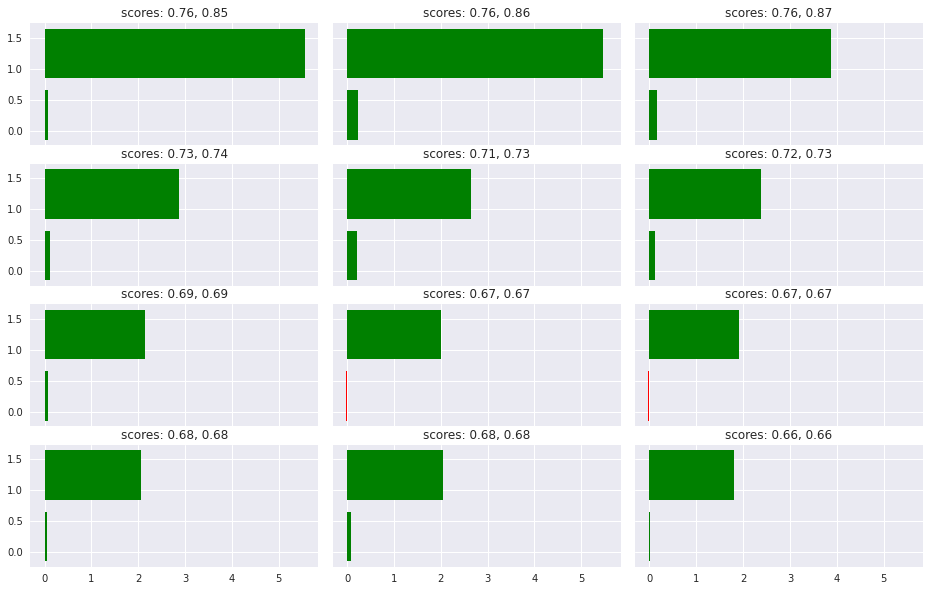

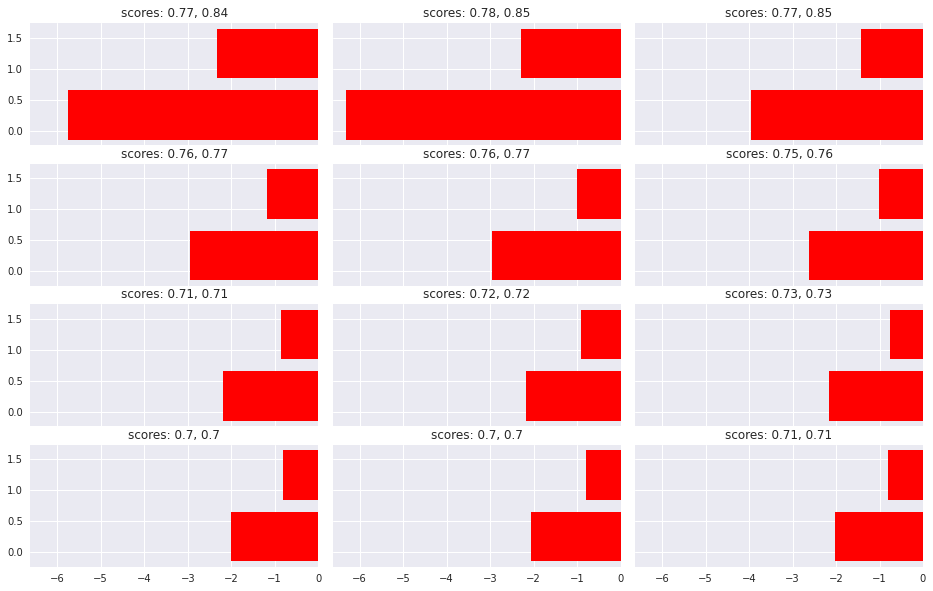

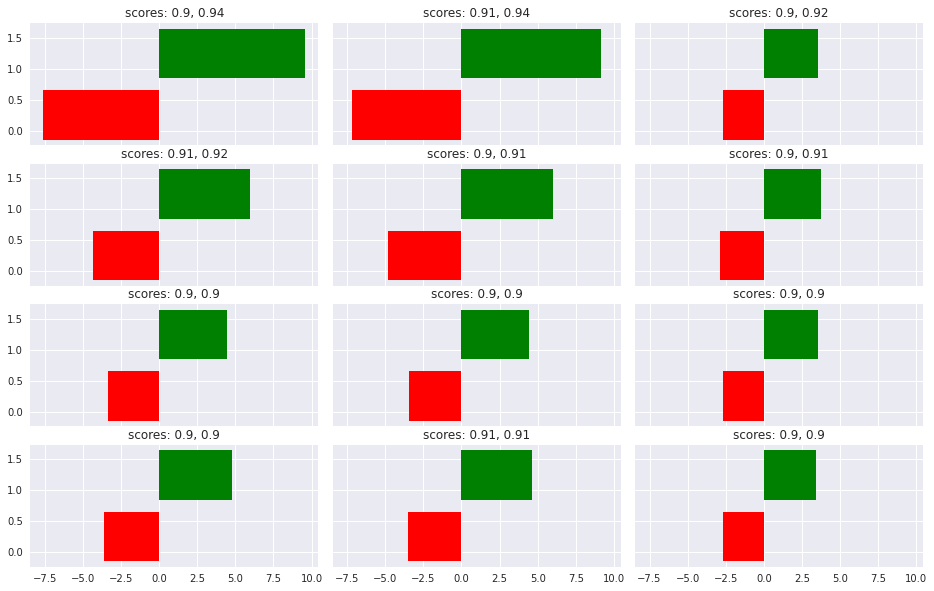

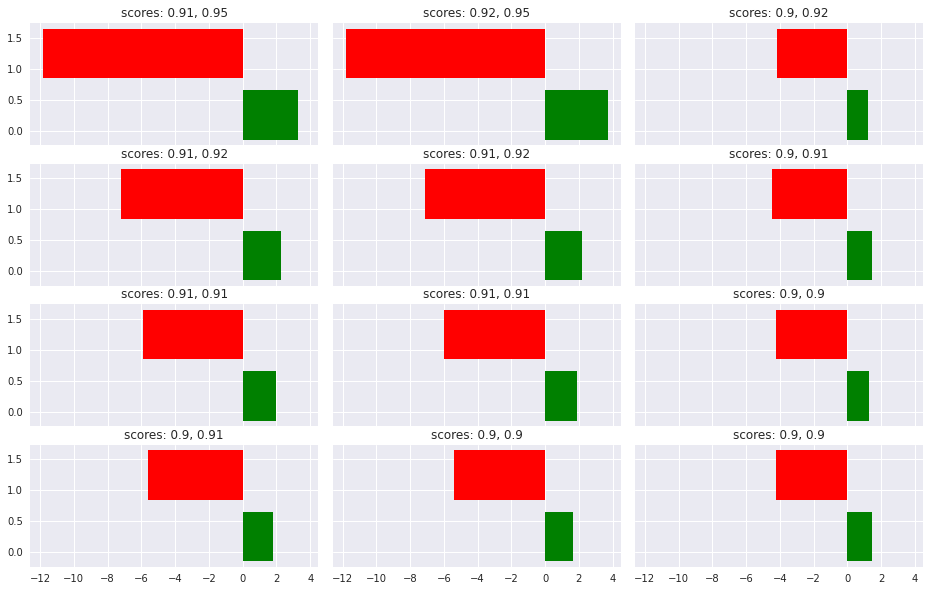

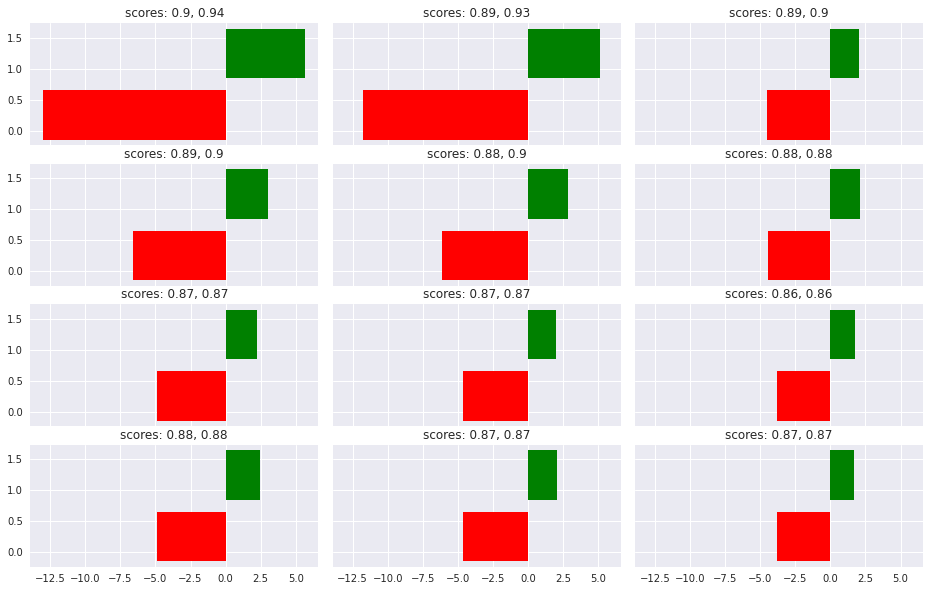

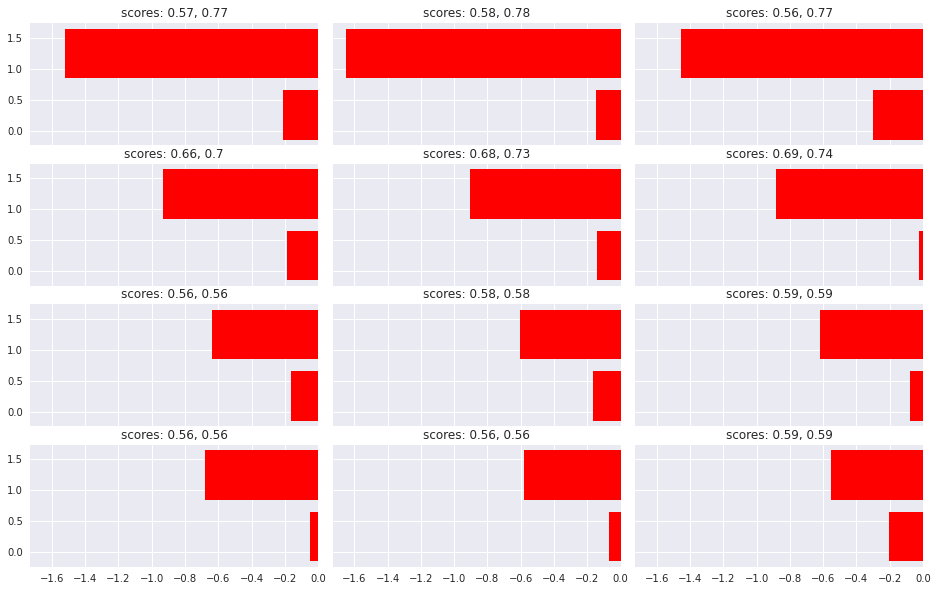

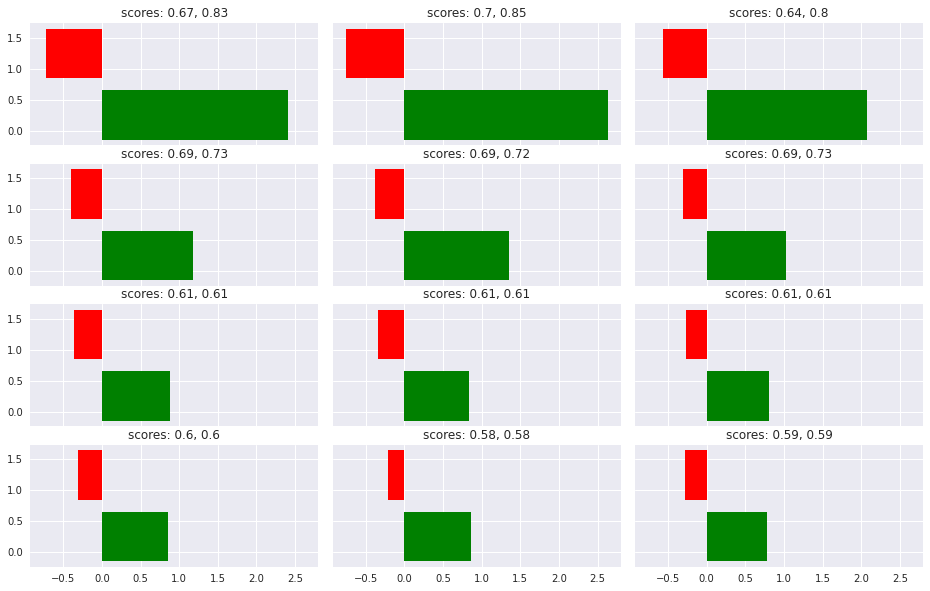

In [207]:
kws = [0.50, 1, 3, 5]
Cs = [1000, 10, 0.1]

nkws = len(kws)
npen = len(Cs)

indices = np.random.choice(range(500), 10).tolist()

for idx in indices:
    fig, axes = plt.subplots(
        nkws, npen,
        figsize=(4*nkws, 2*npens),
        sharex=True, sharey=True,
        gridspec_kw={
            "hspace": 0.15,
            "wspace": 0.05,
        }
    )

    for ii, kw in enumerate(kws):
        for jj, C in enumerate(Cs):
            ax = axes[ii, jj]

            coefs, scores = _explain(
                clf,
                X,
                X[idx, :].ravel(),
                penalty='l2',
                kw=kw,
                C=C,
            )

            positions = [i + 0.25 for i in range(len(coefs))]
            colours = ['green' if val > 0 else 'red' for val in coefs]

            ax.barh(positions, coefs, align='center', color=colours)
            ax.set_title(f'scores: {round(scores[0], 2)}, {round(scores[1], 2)}')

In [195]:
coefs

array([[  9.98708632, -11.16171113]])